# **Recommending developers suitable for resolving incident/bug**

Use Case: Finding right developer to work on a newly created Incident/Bug

Features:
1. Maximum number of developer suggested is customizable
2. Developers are suggested on the basis of previous tasks which they have worked upon.


# Installation of Sentence Transformers

In [1]:
!pip install -U sentence-transformers

     |████████████████████████████████| 92kB 4.6MB/s 
     |████████████████████████████████| 2.5MB 8.8MB/s 
     |████████████████████████████████| 1.2MB 29.0MB/s 
     |████████████████████████████████| 901kB 39.2MB/s 
     |████████████████████████████████| 3.3MB 39.2MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.0.0-cp37-none-any.whl size=126711 sha256=e7521ca7464e56c678c91c4daf728e02bbc648ca4a84afc69efa81301ee8bc60
  Stored in directory: /root/.cache/pip/wheels/38/d2/98/d191289a877a34c68aa67e05179521e060f96394a3e9336be6
Successfully built sentence-transformers
ERROR: transformers 4.8.1 has requirement huggingface-hub==0.0.12, but you'll have huggingface-hub 0.0.13 which is incompatible.


# Import Libraries

In [2]:
from sentence_transformers import SentenceTransformer, util
from sentence_transformers import models, losses
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# Mount Google Drive where Jira Dataset is present
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
# Read Jira Dataset
df=pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/jira_dataset_prediction.csv')
df.head()

,Summary,Issue key,Issue id,Parent id,Issue Type,Status,Project key,Project name,Project type,Project lead,Project description,Project url,Priority,Resolution,Assignee,Reporter,Creator,Created,Updated,Last Viewed,Resolved,Due Date,Votes,Labels,Description,Environment,Watchers,Watchers.1,Log Work,Log Work.1,Original Estimate,Remaining Estimate,Time Spent,Work Ratio,Σ Original Estimate,Σ Remaining Estimate,Σ Time Spent,Security Level,Inward issue link (Cloners),Inward issue link (Cloners).1,Outward issue link (Cloners),Inward issue link (Relates),Inward issue link (Relates).1,Inward issue link (Relates).2,Outward issue link (Relates),Outward issue link (Relates).1,Outward issue link (Relates).2,Outward issue link (Relates).3,Custom field (Epic Color),Custom field (Epic Link),Custom field (Epic Name),Custom field (Epic Status),Custom field (Rank),Sprint,Sprint.1,Custom field (Story Points),Comment,Comment.1
0,Help other team with classification model,PITL1-141,11693,NaN,Task,Done,PITL1,Team L1 – Learning From Heterogeneous Develope...,software,nikanmog,NaN,NaN,Medium,Done,zhiyiniu,nikanmog,nikanmog,6/26/2021 14:42,6/28/2021 18:10,6/28/2021 23:42,6/28/2021 18:10,NaN,0,NaN,NaN,NaN,nikanmog,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0|i004by:,Sprint 3 - Week 2,NaN,NaN,NaN,NaN
1,Create json for chord graph,PITL1-140,11692,NaN,Task,Open,PITL1,Team L1 – Learning From Heterogeneous Develope...,software,nikanmog,NaN,NaN,Medium,NaN,ga65hif,nikanmog,nikanmog,6/26/2021 14:41,6/26/2021 14:41,6/28/2021 23:44,NaN,NaN,0,NaN,NaN,NaN,nikanmog,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0|i004bx:,Sprint 3 - Week 2,NaN,NaN,NaN,NaN
2,Getting analysis result in json,PITL1-139,11691,NaN,Task,Open,PITL1,Team L1 – Learning From Heterogeneous Develope...,software,nikanmog,NaN,NaN,Medium,NaN,zhiyiniu,zhiyiniu,zhiyiniu,6/26/2021 12:18,6/26/2021 14:33,6/28/2021 23:44,NaN,NaN,0,NaN,NaN,NaN,zhiyiniu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PITL1-133,NaN,NaN,0|i004bw:,Sprint 3 - Week 1,Sprint 3 - Week 2,NaN,NaN,NaN
3,Finding a proper graph to display output,PITL1-138,11690,NaN,Task,Done,PITL1,Team L1 – Learning From Heterogeneous Develope...,software,nikanmog,NaN,NaN,Medium,Done,zhiyiniu,zhiyiniu,zhiyiniu,6/26/2021 12:17,6/26/2021 12:22,6/28/2021 23:44,6/26/2021 12:22,NaN,0,NaN,NaN,NaN,zhiyiniu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PITL1-133,NaN,NaN,0|i004ev:,NaN,NaN,NaN,NaN,NaN
4,Counting lines of code changes per person,PITL1-137,11689,NaN,Task,Done,PITL1,Team L1 – Learning From Heterogeneous Develope...,software,nikanmog,NaN,NaN,Medium,Done,zhiyiniu,zhiyiniu,zhiyiniu,6/26/2021 12:16,6/26/2021 12:21,6/28/2021 23:44,6/26/2021 12:21,NaN,0,NaN,NaN,NaN,zhiyiniu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PITL1-133,NaN,NaN,0|i004en:,NaN,NaN,NaN,NaN,NaN


# Data Preprocessing


*   Merging data frames
*   Selecting essential features while removing the rest
*   Cleaning data : Fetching and eliminating null values






In [41]:
# Keeping the following useful essential columns: Summary, Issue id, Description,Assignee,Reporter
df = df.filter(['Summary', 'Issue id','Issue key', 'Description','Assignee','Reporter'])
df.head()

,Summary,Issue id,Issue key,Description,Assignee,Reporter
0,Help other team with classification model,11693,PITL1-141,NaN,zhiyiniu,nikanmog
1,Create json for chord graph,11692,PITL1-140,NaN,ga65hif,nikanmog
2,Getting analysis result in json,11691,PITL1-139,NaN,zhiyiniu,zhiyiniu
3,Finding a proper graph to display output,11690,PITL1-138,NaN,zhiyiniu,zhiyiniu
4,Counting lines of code changes per person,11689,PITL1-137,NaN,zhiyiniu,zhiyiniu


In [42]:
#data summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Summary      141 non-null    object
 1   Issue id     141 non-null    int64 
 2   Issue key    141 non-null    object
 3   Description  40 non-null     object
 4   Assignee     141 non-null    object
 5   Reporter     141 non-null    object
dtypes: int64(1), object(5)
memory usage: 6.7+ KB


In [7]:
# Check for null values
df[df.isnull().any(axis=1)]

# Drop rows with null Values
df.drop(df[df.isnull().any(axis=1)].index,inplace=True)
df=df.reset_index(drop=True)
df.head(8)

,Summary,Issue id,Issue key,Description,Assignee,Reporter
0,Add mapping of username,11562,PITL1-107,{color:#172b4d}Some users can appear with mult...,nikanmog,ga65hif
1,Create Initial prototype,11561,PITL1-106,Develop a working prototype,ga65hif,ga65hif
2,Getting usable data out of a git repository,11560,PITL1-105,Research how to best get a table of data from ...,ga65hif,ga65hif
3,Predicted Result Formatting,11547,PITL1-104,Aggregate the predicted result in JSON format ...,saurypande,saurypande
4,Estimate commit entropy,11510,PITL1-103,How much a developer would change in a file pe...,ga65hif,ga65hif
5,Change time to cyclical representation,11364,PITL1-80,"Initial model showed issues, with estimated ti...",ga65hif,ga65hif
6,Create working prototype,11363,PITL1-79,Create an inital prototype to show viability,ga65hif,ga65hif
7,Write personal reflection report,11328,PITL1-57,* *Personal reflection report [everyone]* [PDF...,zhiyiniu,nikanmog


In [49]:
# Using first description and summary as a sample query i.e assigned incident
df["Description"].fillna(df['Summary'], inplace = True)
query = df['Description'][4]
summary_query = df['Summary'][4]

# Model Selection and Initialization
1. Model Name : stsb-roberta-large, Base Model: roberta-base, Pooling: Mean Pooling, Training Data: NLI+STSb, STSb Performance: 86.39   Size: 1.31G
2. Model Name : bert-base-nli-mean-tokens, STSb Performance: 76.3,  Size: ~400MB

In [9]:
model = SentenceTransformer('stsb-roberta-base-v2')

In [50]:
#Converting the incidents description text to contextual embeddings
query_embedding = model.encode(query, batch_size = 1, show_progress_bar = True)
text_embeddings = model.encode(df['Description'], batch_size = len(df['Description']), show_progress_bar = True)

In [51]:
#Converting the incidents summary text to contextual embeddings
summary_query_embedding = model.encode(summary_query, batch_size = 1, show_progress_bar = True)
summary_text_embeddings = model.encode(df['Summary'], batch_size = len(df['Summary']), show_progress_bar = True)

In [46]:
#Embedding size of each document
print("Embedding Size:", text_embeddings.size)

#Total number of documents present
print("Total no of documents", len(text_embeddings))

Embedding Size: 108288
Total no of documents 141


In [ ]:
# Save model offline ---Don't Run---
import pickle
with open('stsb-roberta-base-v2','wb') as f:
  pickle.dump(model,f) 

In [ ]:
# Saving embeddings of the Jira File ---Don't Run---
np.savez_compressed('summary_embeddings.npz', text_embeddings=text_embeddings)

# Load saved embeddings
#loaded = np.load('text_embedding.npz')

# Suggest developers Based on Search Incident 

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Summary      141 non-null    object
 1   Issue id     141 non-null    int64 
 2   Issue key    141 non-null    object
 3   Description  141 non-null    object
 4   Assignee     141 non-null    object
 5   Reporter     141 non-null    object
dtypes: int64(1), object(5)
memory usage: 6.7+ KB


In [52]:
print("Query Sentence:", query)
# Compute similarity scores of the sentence with the corpus
desc_cos_scores=[]
desc_cos_scores = util.pytorch_cos_sim(query_embedding, text_embeddings)[0]


Query Sentence: Counting lines of code changes per person


In [53]:
cos_scores_summary = util.pytorch_cos_sim(summary_text_embeddings[2], summary_text_embeddings)[0]

# Merge both the description scores and summary scores
total_scores=(0.65)*desc_cos_scores+(0.35)*cos_scores_summary

#total_scores = util.pytorch_cos_sim(query_embedding, text_embeddings)[0]
# Sort the results in decreasing order 
top_results = np.argpartition(-total_scores, range(len(total_scores)))[0:len(total_scores)]
print("Sentence:", query, "\n")

result={}
for idx in top_results[1:len(total_scores)]:
    if(total_scores[idx]>0.35):
        if df['Assignee'][int(idx)] not in result:
            result[df['Assignee'][int(idx)]]=0;
        result[df['Assignee'][int(idx)]]+=round(float(total_scores[idx]),4);
        result[df['Assignee'][int(idx)]]=round(result[df['Assignee'][int(idx)]],4);

print(result)
sort_dict= dict(sorted(result.items(), key=lambda item: item[1],reverse=True))

Sentence: Counting lines of code changes per person 

{'ga65hif': 2.3071, 'zhiyiniu': 1.5509, 'saurypande': 1.1011, 'nikanmog': 0.7436}


Searched Incident:  Counting lines of code changes per person
['ga65hif', 'zhiyiniu', 'saurypande', 'nikanmog']
[2.3071, 1.5509, 1.1011, 0.7436]


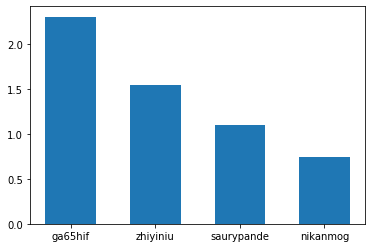

In [54]:
import matplotlib.pyplot as plt

print("Searched Incident: ",summary_query)

names = list(sort_dict.keys())[0:6]
values = list(sort_dict.values())[0:6]
print(names)
print(values)
plt.bar(range(len(values)), values, tick_label=names, width=0.6)
plt.show()

# Export aggregated result as JSON

In [55]:
import json

aggregate_result=[]
for i in range(len(df['Description'])):
  desc_cos_scores = util.pytorch_cos_sim(text_embeddings[i], text_embeddings)[0]
  # Compute similarity scores of the incidents 
  cos_scores_summary = util.pytorch_cos_sim(summary_text_embeddings[i], summary_text_embeddings)[0]

  # Merge both the description scores and summary scores
  total_scores=(0.7)*desc_cos_scores+(0.3)*cos_scores_summary

  # Sort the results in decreasing order and get the first top_k result
  top_results = np.argpartition(-total_scores, range(len(total_scores)))[0:len(total_scores)]

  result={}
  response=[]

  #Select developers only with a threshold similarity score of 0.30
  for idx in top_results[1:len(total_scores)]:
    if(total_scores[idx]>0.34):
        if df['Assignee'][int(idx)] not in result:
            result[df['Assignee'][int(idx)]]=0;
        result[df['Assignee'][int(idx)]]+=round(float(total_scores[idx]),4);
        result[df['Assignee'][int(idx)]]=round(result[df['Assignee'][int(idx)]],4);
  
  sort_dict= dict(sorted(result.items(), key=lambda item: item[1],reverse=True))

  names = list(sort_dict.keys())[0:6]
  values = list(sort_dict.values())[0:6]

  dict_store=[]
  for index in range(4):
    temp={}
    if(len(names)-1>=index):
      temp['username']=names[index]
      temp['score']=values[index]
      temp['issuekey']=df['Issue key'][i]	
      temp['summary']=df['Summary'][i]
    dict_store.append(temp) 

  aggregate_result.append(dict_store)

print(aggregate_result)

response=json.dumps(aggregate_result)
with open("response.json", "w") as outfile:
    outfile.write(response)

[[{'username': 'saurypande', 'score': 4.9794, 'issuekey': 'PITL1-141', 'summary': 'Help other team with classification model'}, {'username': 'zhiyiniu', 'score': 2.7351, 'issuekey': 'PITL1-141', 'summary': 'Help other team with classification model'}, {'username': 'ga65hif', 'score': 2.2366, 'issuekey': 'PITL1-141', 'summary': 'Help other team with classification model'}, {'username': 'nikanmog', 'score': 0.7674, 'issuekey': 'PITL1-141', 'summary': 'Help other team with classification model'}], [{'username': 'nikanmog', 'score': 3.229, 'issuekey': 'PITL1-140', 'summary': 'Create json for chord graph'}, {'username': 'zhiyiniu', 'score': 2.8016, 'issuekey': 'PITL1-140', 'summary': 'Create json for chord graph'}, {'username': 'saurypande', 'score': 1.7189, 'issuekey': 'PITL1-140', 'summary': 'Create json for chord graph'}, {'username': 'ga65hif', 'score': 1.4138, 'issuekey': 'PITL1-140', 'summary': 'Create json for chord graph'}], [{'username': 'saurypande', 'score': 3.8128, 'issuekey': '